## Atlas Based Registration Project
In this notebook, the registration pipeline of the baseline model is combined in a more compact code. This makes it easier to register a series of atlas images (training data) to the fixed image (validation data). Only the `ELASTIC_PATH` and `TRANSFORMIX_PATH` need to be changed based on your own directory. Make sure that the DevelopmentData folder is filled with the patient folders: p102, p107, etc.


In [1]:
# Library imports
import matplotlib.pyplot as plt
import imageio.v3 as iio
import numpy as np
import elastix
import os

from sklearn.model_selection import train_test_split

# General file paths
BASE_PATH = "../DevelopmentData"
MR_PATHS = [os.path.join(BASE_PATH, f, "mr_bffe.mhd") for f in os.listdir(BASE_PATH) if not f.startswith('.')]
MASK_PATHS = [os.path.join(BASE_PATH, f, "prostaat.mhd") for f in os.listdir(BASE_PATH) if not f.startswith('.')]

# Change these paths based on own directory!
ELASTIX_PATH = os.path.join(r'C:/Tue/CapitaFolder/elastix.exe')
TRANSFORMIX_PATH = os.path.join(r'C:/Tue/CapitaFolder/transformix.exe')

if not os.path.exists(ELASTIX_PATH):
    raise IOError('Elastix cannot be found, please set the correct ELASTIX_PATH.')
if not os.path.exists(TRANSFORMIX_PATH):
    raise IOError('Transformix cannot be found, please set the correct TRANSFORMIX_PATH.')

The following code splits the data paths into a training (n=12) and validation (n=3) set in order to assess the performance of the atlas-based registration method for obtaining prostate segmentations.  

In [2]:
split_size = 5  # Each test set contains 5 images and 5 masks
num_splits = len(MR_PATHS) // split_size  # Determine the number of splits (3 splits for 15 images)

# Initialize lists to hold the results of each split
mr_train_splits = []
mr_test_splits = []
mask_train_splits = []
mask_test_splits = []

# Perform the splits manually
for i in range(num_splits):
    # The starting index for the test set in this iteration
    test_start = i * split_size
    test_end = test_start + split_size
    
    # Define the test set
    mr_test = MR_PATHS[test_start:test_end]
    mask_test = MASK_PATHS[test_start:test_end]
    
    # Define the train set (everything not in the test set)
    mr_train = MR_PATHS[:test_start] + MR_PATHS[test_end:]
    mask_train = MASK_PATHS[:test_start] + MASK_PATHS[test_end:]
    
    # Append the results for this split
    mr_train_splits.append(mr_train)
    mr_test_splits.append(mr_test)
    mask_train_splits.append(mask_train)
    mask_test_splits.append(mask_test)

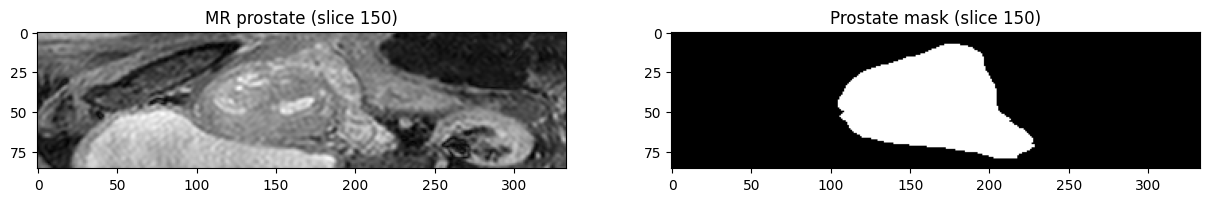

In [4]:
# Load example of patient data
mr_example = iio.imread(mr_train_splits[0][0])
mask_example = iio.imread(mask_train_splits[0][0])

# Plot example of patient data
slice = 150
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(mr_example[:,:,slice], cmap="gray")
ax[0].set_title(f"MR prostate (slice {slice})")
ax[1].imshow(mask_example[:,:,slice], cmap="gray")
ax[1].set_title(f"Prostate mask (slice {slice})");

# Registration pipeline
In the code block below, a function is defined that performs the full baseline registration process. This includes a rigid registration step for a rough initial alignment, followed by a nonlinear registration step using BSplines. Here, the fixed image represents an image with unknown mask (validation data) and the moving image is an atlas image with known mask (training data). The deformation field obtained from this registration pipeline is applied to the mask of the moving image.

In [19]:
def registration_pipeline(fixed_image_path, moving_image_path, moving_mask_path):
    """
    """
    # Make a results directory if non exists
    if os.path.exists("results_baseline/rigid") is False:
        os.makedirs(os.path.join("results_baseline/rigid"))
    
    # Define a new elastix object 'el' with the correct path to elastix
    el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)

    # Execute the rigid registration step
    el.register(
        fixed_image=fixed_image_path,
        moving_image=moving_image_path,
        parameters=["parameters_baseline_rigid.txt"],
        output_dir="results_baseline/rigid"
    )   

    # Find result of rigid registration
    rigid_transformed_image_path = os.path.join('results_baseline/rigid', 'result.0.mhd')
    rigid_transform_path = os.path.join('results_baseline/rigid', 'TransformParameters.0.txt')

    # Make a new transformix object tr with the CORRECT PATH to transformix
    tr = elastix.TransformixInterface(parameters=rigid_transform_path, transformix_path=TRANSFORMIX_PATH)
    
    # Transform the mask with the transformation parameters
    rigid_transformed_mask_path = tr.transform_image(moving_mask_path, output_dir=os.path.join('results_baseline/rigid'))   

    # Make a results directory if non exists
    if os.path.exists("results_baseline/nonlinear") is False:
        os.makedirs(os.path.join("results_baseline/nonlinear"))

    # Execute the nonlinear registration step
    el.register(
        fixed_image=fixed_image_path,
        moving_image=rigid_transformed_image_path,
        parameters=["parameters_baseline_nonlinear.txt"],
        output_dir="results_baseline/nonlinear"
    )

    # Find result of nonlinear registration
    nonlinear_transform_path = os.path.join('results_baseline/nonlinear', 'TransformParameters.0.txt')

    # Make a new transformix object tr with the CORRECT PATH to transformix
    tr = elastix.TransformixInterface(parameters=nonlinear_transform_path, transformix_path=TRANSFORMIX_PATH)

    # Transform the mask with the transformation parameters
    nonlinear_transformed_mask_path = tr.transform_image(rigid_transformed_mask_path, output_dir=os.path.join('results_baseline/nonlinear'))

    return nonlinear_transformed_mask_path

In [ ]:
# ADD AUGMENTATION IMAGES HERE

aug_mr_train_paths = [] 
aug_mask_train_paths = [] 

The registration pipeline is called iteratively to create all altas segmentations for an image in the validation set. The masks are loaded into a numpy array and used in the following processing steps.

In [20]:
atlas_masks = []
for test_idx in range(1):
    # Loop over images in the testing set
    fixed_image_path = mr_test_paths[test_idx]

    for train_idx in range(len(mr_train_paths)):
        # Loop over images in the training set
        moving_image_path = mr_train_paths[train_idx]
        moving_mask_path = mask_train_paths[train_idx]

        # Call registration pipeline and store deformed atlas masks
        new_atlas_mask_path = registration_pipeline(fixed_image_path, moving_image_path, moving_mask_path)
        atlas_masks.append(iio.imread(new_atlas_mask_path))

# Convert to numpy array
atlas_masks = np.array(atlas_masks)

C:/Tue/CapitaFolder/elastix.exe -f ../DevelopmentData\p129\mr_bffe.mhd -m ../DevelopmentData\p102\mr_bffe.mhd -p parameters_baseline_rigid.txt -out results_baseline/rigid
C:/Tue/CapitaFolder/elastix.exe -f ../DevelopmentData\p129\mr_bffe.mhd -m results_baseline/rigid\result.0.mhd -p parameters_baseline_nonlinear.txt -out results_baseline/nonlinear
C:/Tue/CapitaFolder/elastix.exe -f ../DevelopmentData\p129\mr_bffe.mhd -m ../DevelopmentData\p107\mr_bffe.mhd -p parameters_baseline_rigid.txt -out results_baseline/rigid
C:/Tue/CapitaFolder/elastix.exe -f ../DevelopmentData\p129\mr_bffe.mhd -m results_baseline/rigid\result.0.mhd -p parameters_baseline_nonlinear.txt -out results_baseline/nonlinear
C:/Tue/CapitaFolder/elastix.exe -f ../DevelopmentData\p129\mr_bffe.mhd -m ../DevelopmentData\p108\mr_bffe.mhd -p parameters_baseline_rigid.txt -out results_baseline/rigid
C:/Tue/CapitaFolder/elastix.exe -f ../DevelopmentData\p129\mr_bffe.mhd -m results_baseline/rigid\result.0.mhd -p parameters_basel

The following figure displays the original mask of the testing sample on top. The following twelve images show the deformed masks based on the atlas images in the training set

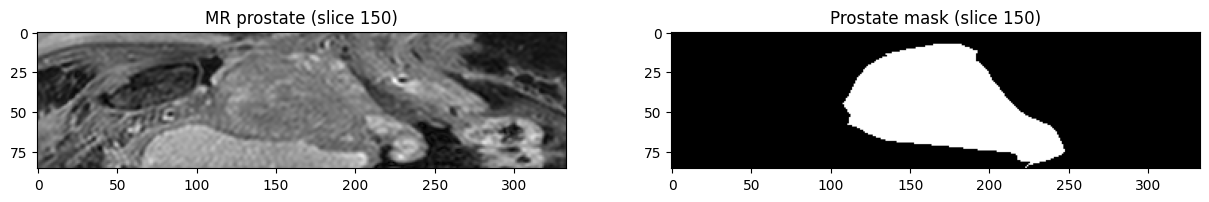

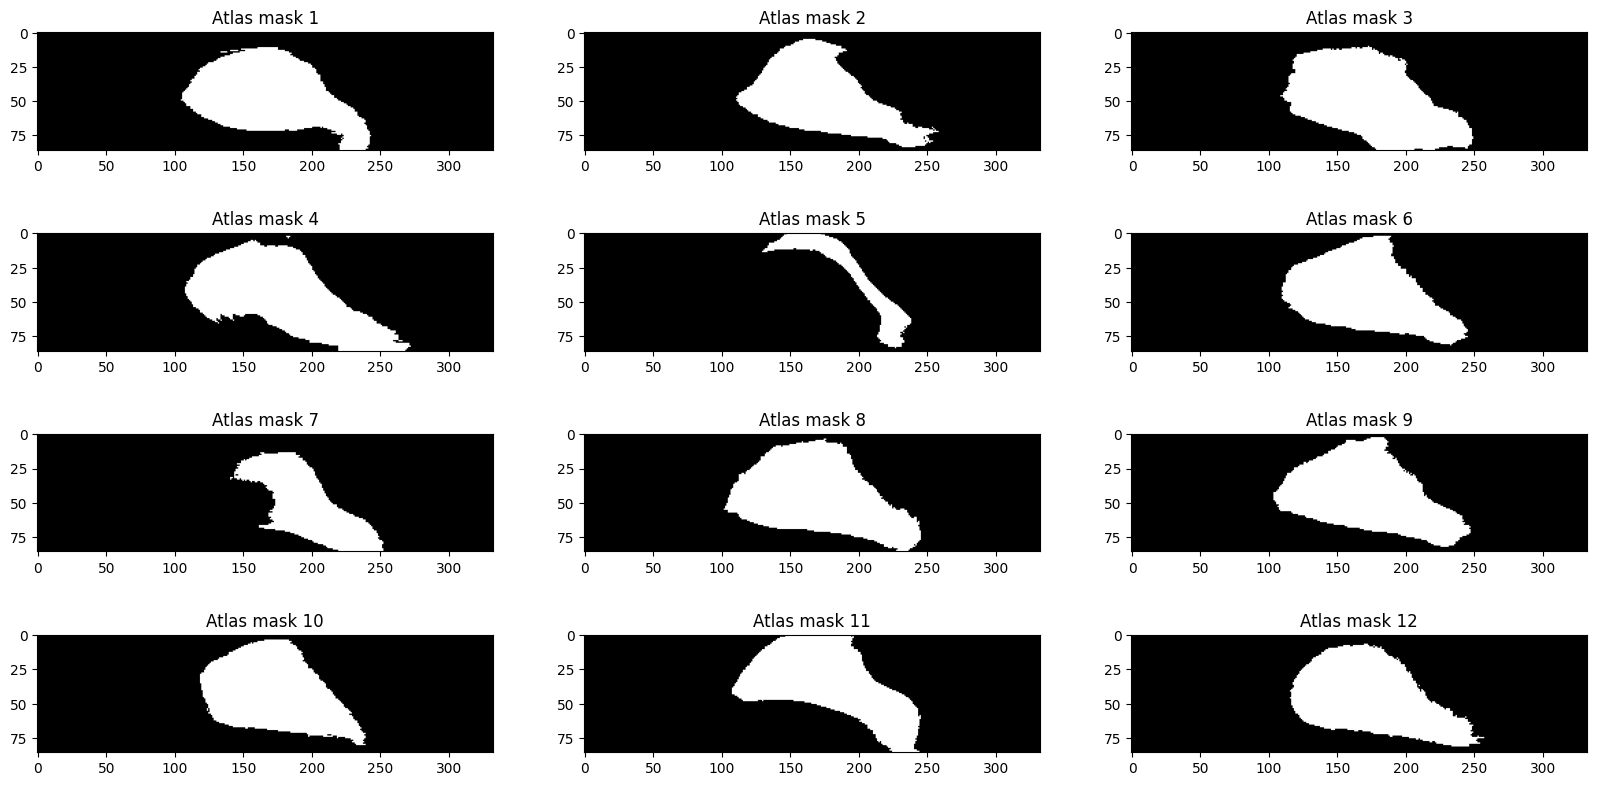

In [ ]:
# Testing sample
slice = 150
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(iio.imread(mr_test_paths[0])[:,:,slice], cmap="gray")
ax[0].set_title(f"MR prostate (slice {slice})")
ax[1].imshow(iio.imread(mask_test_paths[0])[:,:,slice], cmap="gray")
ax[1].set_title(f"Prostate mask (slice {slice})");

# Atlas image segmentations
fig, ax = plt.subplots(4, 3, figsize=(20, 10))
ax = ax.flatten()
for idx in range(len(atlas_masks)):
    ax[idx].imshow(atlas_masks[idx][:,:,slice], cmap="gray")
    ax[idx].set_title(f"Atlas mask {idx + 1}");

Combining the figures results in a new segmentation with values between 0 and 12. A threshold can be chosen to create the finalized segmentation.

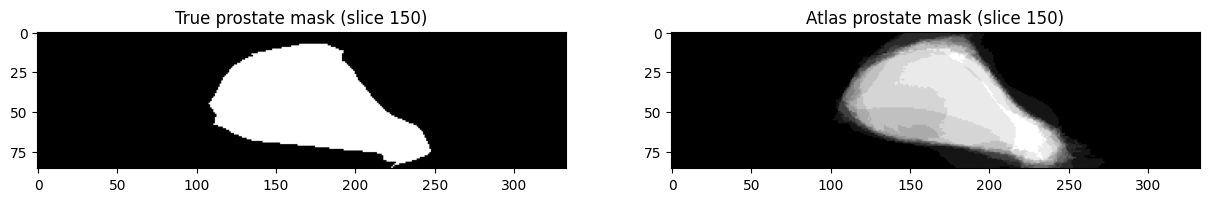

In [21]:
total_mask = 0
for mask in atlas_masks:
    total_mask += mask

slice = 150
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(iio.imread(mask_test_paths[0])[:,:,slice], cmap="gray")
ax[0].set_title(f"True prostate mask (slice {slice})");
ax[1].imshow(total_mask[:,:,slice], cmap="gray")
ax[1].set_title(f"Atlas prostate mask (slice {slice})");

In [22]:
def dice_coefficient(mask1, mask2):
    if mask1.shape != mask2.shape:
        raise ValueError("Input masks must have the same shape.")
    
    intersection = np.sum(mask1*mask2)
    volume_sum = np.sum(mask1) + np.sum(mask2)

    if volume_sum == 0:
        return 1.0  # If both masks are empty, they are considered identical
    
    return 2.0 * intersection / volume_sum

total_mask = total_mask > 6.5
print("Dice coefficient:", dice_coefficient(iio.imread(mask_test_paths[0]), total_mask))

Dice coefficient: 0.9283359255400091
